In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd /content/drive/MyDrive/Colab/HSE/LSML_2/Project

/content/drive/MyDrive/Colab/HSE/LSML_2/Project


In [9]:
ls

task_bow.ipynb  test_tweets.csv  train_val_tweets.csv


### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

Credits:

1) This notebook is inspired by [YSDA NLP_course](https://github.com/yandexdataschool/nlp_course)

2) This notebook is originally from this beautiful repo [girafe.ai](https://github.com/girafe-ai/natural-language-processing) HW's

3) Data Courtesy from this [useful epo](https://github.com/sharmaroshan/Twitter-Sentiment-Analysis)

4) Some parts is inspired from this [amazing repo](https://github.com/rasbt/python-machine-learning-book/tree/master/code)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn import svm
from sklearn import tree
import nltk.data
nltk.download('stopwords')
from nltk.corpus import stopwords
import pickle
import re
import sys
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bharani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_val = pd.read_csv('train_val_tweets.csv')
texts = train_val['tweet'].values
target = train_val['label'].values
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.2, random_state=42)
print(texts_train.shape, texts_test.shape, y_train.shape, y_test.shape)

(25569,) (6393,) (25569,) (6393,)


__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [3]:
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenizer = TweetTokenizer()
    text = ' '.join(tokenizer.tokenize(text.lower()))
    return text

texts_train = [preprocessor(t) for t in texts_train]
texts_test = [preprocessor(t) for t in texts_test]

### Build Model and Train

In [4]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
%%time
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
stop = stopwords.words('english')
lr_clf = LogisticRegression(random_state=42)
sgd_clf = SGDClassifier(loss='log_loss', random_state=42)
rf_clf = RandomForestClassifier(n_estimators = 20, random_state=42)
xgb_clf = XGBClassifier(random_state=42)
tree_clf = tree.DecisionTreeClassifier(random_state=42)
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None]},]


all_classifiers = {'lr': lr_clf,
                   'sgd': sgd_clf,
                   'rf': rf_clf,
                   'xgb': xgb_clf,
                   'tree': tree_clf,
                   }

best_models = {}
accuracy_dict = {}
for clf_name, clf in all_classifiers.items():
    tfidf_clf_pipe = Pipeline([('vect', tfidf), ('clf', clf)])
    tfidf_clf_pipe_gs = GridSearchCV(tfidf_clf_pipe, param_grid,
                               scoring='accuracy',
                               verbose=0, cv=3,                            
                               n_jobs=-1)

    tfidf_clf_pipe_gs.fit(texts_train, y_train)
    best_model = tfidf_clf_pipe_gs.best_estimator_
    best_models[clf] = best_model
    y_pred = best_model.predict(texts_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_dict[clf_name] = acc
    print(f'classifier algorithm = {clf_name}')
    print("Number of mislabeled points out of a total %d points : %d" % (len(texts_test), (y_test != y_pred).sum()))
    print('Test Accuracy: %.3f' % acc)

classifier algorithm = lr
Number of mislabeled points out of a total 6393 points : 333
Test Accuracy: 0.948


/home/bharani/.conda/envs/Edu/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/bharani/.conda/envs/Edu/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/bharani/.conda/envs/Edu/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/bharani/.conda/envs/Edu/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which 

classifier algorithm = sgd
Number of mislabeled points out of a total 6393 points : 395
Test Accuracy: 0.938
classifier algorithm = rf
Number of mislabeled points out of a total 6393 points : 277
Test Accuracy: 0.957
classifier algorithm = xgb
Number of mislabeled points out of a total 6393 points : 318
Test Accuracy: 0.950
classifier algorithm = tree
Number of mislabeled points out of a total 6393 points : 355
Test Accuracy: 0.944
CPU times: user 58.5 s, sys: 365 ms, total: 58.9 s
Wall time: 1min 57s


In [6]:
accuracy_dict

{'lr': 0.9479117785077429,
 'sgd': 0.9382136712028781,
 'rf': 0.9566713592992335,
 'xgb': 0.9502580947911778,
 'tree': 0.9444705146253715}

In [7]:
best_model = RandomForestClassifier(n_estimators=20, random_state=42)
best_pipe = Pipeline([('vect', tfidf), ('clf', best_model)])
best_pipe.fit(texts_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(lowercase=False)),
                ('clf',
                 RandomForestClassifier(n_estimators=20, random_state=42))])

In [8]:
y_pred = best_pipe.predict(texts_test)

y_true = y_test
acc = accuracy_score(y_true, y_pred)
print("Number of mislabeled points out of a total %d points : %d" \
          % (len(texts_test), (y_test != y_pred).sum()))

Number of mislabeled points out of a total 6393 points : 280


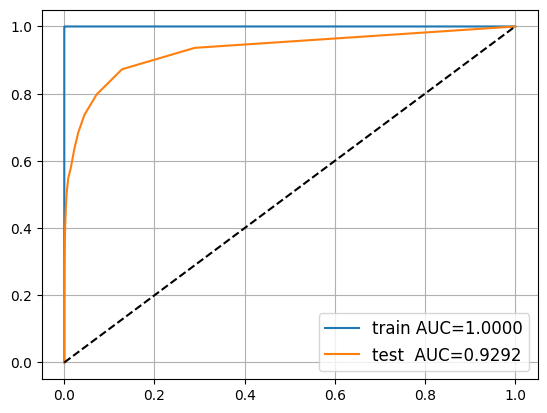

In [9]:
for name, X, y, model in [
    ('train', texts_train, y_train, best_pipe),
    ('test ', texts_test, y_test, best_pipe)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [10]:
pickle.dump(best_model, open('best_pipe.pkl','wb'))

In [11]:
final_model = pickle.load(open('best_pipe.pkl', 'rb'))

In [12]:
tfidf.fit(texts_train)
pickle.dump(tfidf, open('tfidf.pkl','wb'))
transformer = pickle.load(open('tfidf.pkl', 'rb'))

In [13]:
tweet = "@user omfg i'm offended! i'm a  mailbox and i'm proud! #mailboxpride  #liberalisme"

prediction = final_model.predict(transformer.transform([preprocessor(t) for t in [tweet]]))[0]
print(prediction)

1


In [14]:
tweet = "Machine learning is amazing in every sense and i love it"

prediction = final_model.predict(transformer.transform([preprocessor(t) for t in [tweet]]))[0]
print(prediction)

0


In [7]:
# sql
import sqlite3
import os

if os.path.exists('toxic.sqlite'):
    os.remove('toxic.sqlite')

conn = sqlite3.connect('toxic.sqlite')
c = conn.cursor()
c.execute('CREATE TABLE toxic_db (tweet TEXT, toxic INTEGER)')

tweet_1 = 'The world cup 2022 is in qatar and 32 teams are competing'
c.execute("INSERT INTO toxic_db (tweet, toxic) VALUES (?, ?)", (tweet_1, 1))

tweet_2 = 'LSML final assignment has the pipeline of model, deploy and dockerize'
c.execute("INSERT INTO toxic_db (tweet, toxic) VALUES (?, ?)", (tweet_2, 0))

conn.commit()
conn.close()

In [8]:
conn = sqlite3.connect('toxic.sqlite')
c = conn.cursor()

c.execute("SELECT * FROM toxic_db")
results = c.fetchall()

conn.close()

In [9]:
print(results)

[('The world cup 2022 is in qatar and 32 teams are competing', 1), ('LSML final assignment has the pipeline of model, deploy and dockerize', 0)]
